**Using the feature file generated using MobileOne_s4 and imagenet weights**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

In [3]:
import pickle

feature_file = '/content/drive/MyDrive/Dataset/Kvasir/Feature_Extraction/rifat_mobileOne_s4_2048.pkl'

with open(feature_file, 'rb') as file:
    data = pickle.load(file)

# Access the features and labels
features = data['features']
labels = data['labels']

In [4]:
print(features.shape)
print(labels.shape)

(8000, 2048, 7, 7)
(8000,)


In [5]:
features

array([[[[2.05007777e-01, 4.61402582e-03, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.87104549e-02, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.13270216e-01, 1.71468183e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 5.21206796e-01, ...,
          1.58825481e+00, 9.10220504e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          7.85028219e-01, 7.62288511e-01, 1.59375310e+00],
        

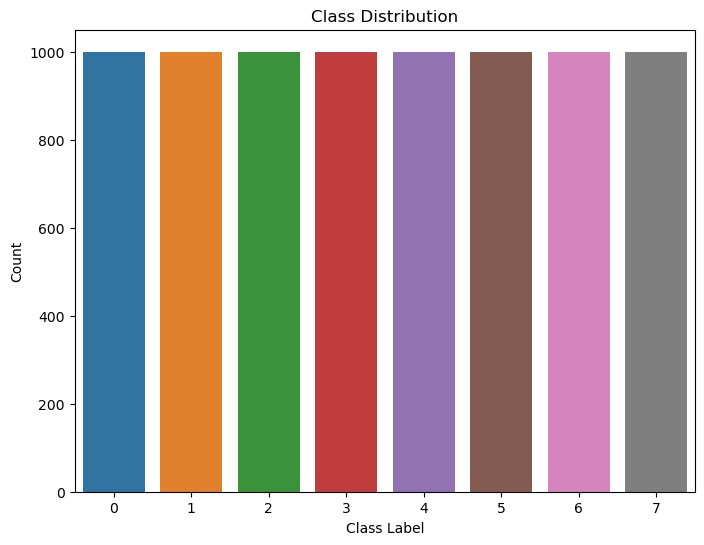

In [ ]:
# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=labels)
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

0. 'dyed-lifted-polyps'
1. 'dyed-resection-margins'
2. 'esophagitis'
3. 'normal-cecum'
4. 'normal-pylorus'
5. 'normal-z-line'
6. 'polyps'
7. 'ulcerative-colitis'





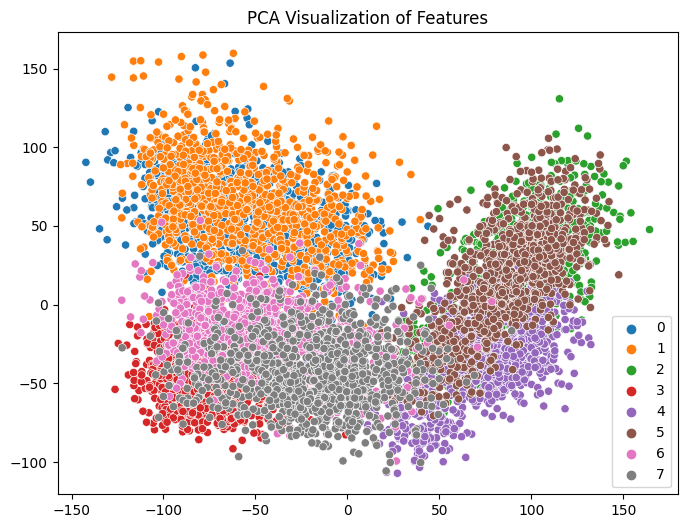

In [7]:
from sklearn.decomposition import PCA

# Reshape the features to be 2D (8000 samples, 2048*7*7 features)
flattened_features = features.reshape(8000, -1)

# Perform PCA to reduce dimensions
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(flattened_features)

# Plot the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='tab10')
plt.title("PCA Visualization of Features")
plt.show()


Silhouette Score for K-means with PCA: 0.38905212


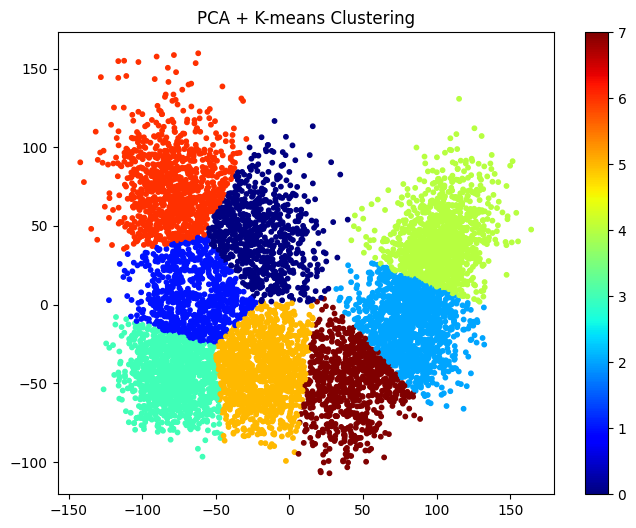

In [8]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

# Apply PCA and then K-means with hyperparameter tuning
param_grid_kmeans = {
    'n_init': [5, 10, 15],
    'max_iter': [100, 200, 300]
}

pca = PCA(n_components=2, random_state=42)
x_pca = pca.fit_transform(flattened_features)

kmeans_pca = KMeans(random_state=42, n_clusters=8)
grid_search_kmeans_pca = GridSearchCV(kmeans_pca, param_grid_kmeans, cv=3)
grid_search_kmeans_pca.fit(x_pca)

best_kmeans_pca = grid_search_kmeans_pca.best_estimator_
labels_kmeans_pca = best_kmeans_pca.predict(x_pca)

# Compute Silhouette Score for K-means with PCA
silhouette_avg_pca = silhouette_score(x_pca, labels_kmeans_pca)
print("Silhouette Score for K-means with PCA:", silhouette_avg_pca)

plt.figure(figsize=(8, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=labels_kmeans_pca, cmap='jet', s=10)
plt.colorbar()
plt.title('PCA + K-means Clustering')
plt.show()

Best hyperparameters for K-means with Truncated SVD: {'max_iter': 100, 'n_init': 15}


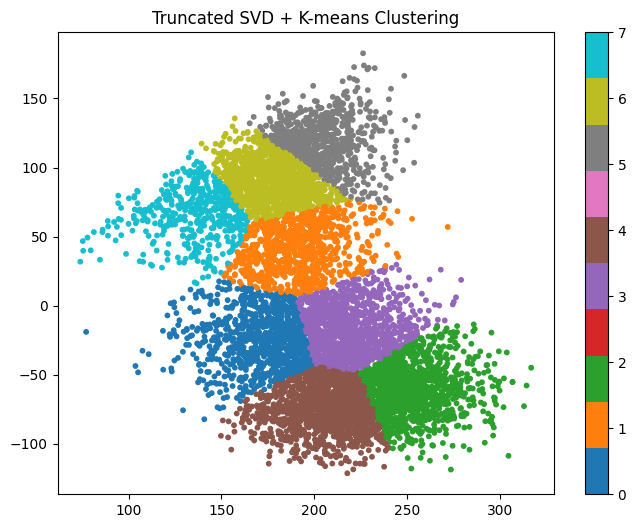

Silhouette Score for Truncated SVD + K-means: 0.34974706


In [9]:
from sklearn.decomposition import TruncatedSVD

# Applying Truncated SVD
tsvd = TruncatedSVD(n_components=2, random_state=42)
x_tsvd = tsvd.fit_transform(flattened_features)


# Apply K-means with hyperparameter tuning for Truncated SVD
param_grid_kmeans_tsvd = {
    'n_init': [5, 10, 15],
    'max_iter': [100, 200, 300]
}

kmeans_tsvd = KMeans(random_state=42, n_clusters=8)
grid_search_kmeans_tsvd = GridSearchCV(kmeans_tsvd, param_grid_kmeans_tsvd, cv=3)
grid_search_kmeans_tsvd.fit(x_tsvd)

# Best hyperparameters for K-means with Truncated SVD
best_kmeans_tsvd = grid_search_kmeans_tsvd.best_estimator_
print("Best hyperparameters for K-means with Truncated SVD:", grid_search_kmeans_tsvd.best_params_)

# Applying K-means with the best Truncated SVD
labels_kmeans_tsvd = best_kmeans_tsvd.predict(x_tsvd)

# Plot Truncated SVD + K-means result
plt.figure(figsize=(8, 6))
plt.scatter(x_tsvd[:, 0], x_tsvd[:, 1], c=labels_kmeans_tsvd, cmap='tab10', s=10)
plt.colorbar()
plt.title('Truncated SVD + K-means Clustering')
plt.show()

# Calculate the silhouette score for Truncated SVD + K-means
silhouette_avg_tsvd = silhouette_score(x_tsvd, labels_kmeans_tsvd)
print("Silhouette Score for Truncated SVD + K-means:", silhouette_avg_tsvd)


### K means Clustering and elbow method

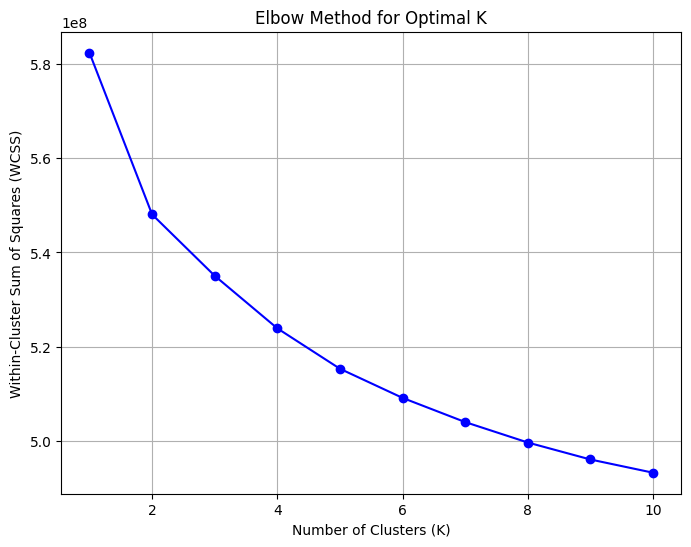

In [9]:
from sklearn.cluster import KMeans

# Create an empty list to store the within-cluster sum of squares (WCSS) for different K values
wcss = []

k_values = range(1, 11)

# Calculate WCSS for each K value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(flattened_features)
    wcss.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()


## Classification

In [10]:
X = features.reshape((8000, -1))  # Reshape to (8000, 2048*7*7)
y = labels
num_classes = len(np.unique(labels))

# Split the data into train(85%), and test(15%) sets with class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# Get the count of samples for each class in each set
train_class_counts = [sum(y_train == i) for i in range(num_classes)]
test_class_counts = [sum(y_test == i) for i in range(num_classes)]

# Print the counts for each class in each set
for class_label, train_count, test_count in zip(range(num_classes), train_class_counts, test_class_counts):
    print(f"Class {class_label}: Train {train_count}, Test {test_count}")

Class 0: Train 850, Test 150
Class 1: Train 850, Test 150
Class 2: Train 850, Test 150
Class 3: Train 850, Test 150
Class 4: Train 850, Test 150
Class 5: Train 850, Test 150
Class 6: Train 850, Test 150
Class 7: Train 850, Test 150


In [11]:
print(X_train.shape)
print(X_test.shape)

(6800, 100352)
(1200, 100352)


In [12]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    class_labels = np.unique(y_test)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, f1, cm


### Random Forest

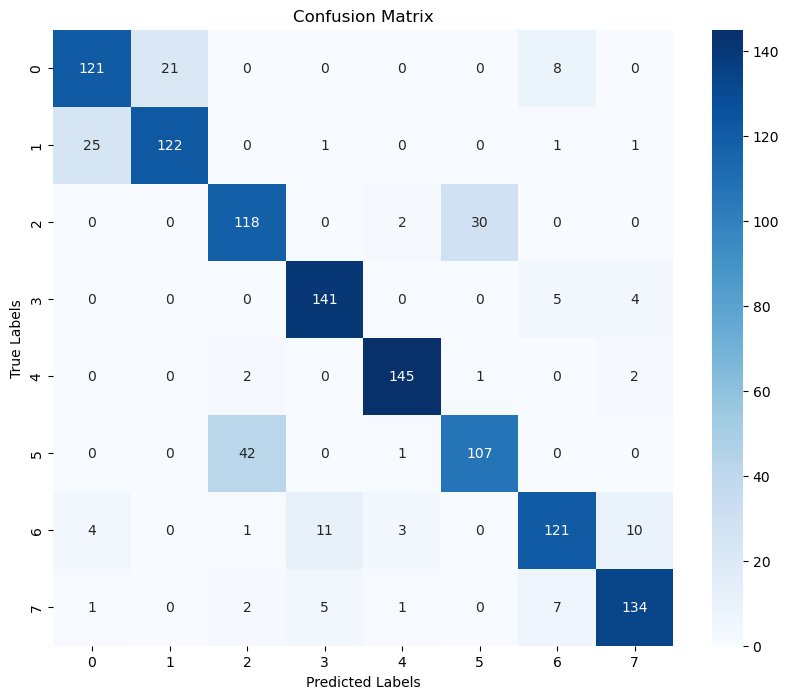

Accuracy: 0.8408333333333333
F1 Score: 0.8404993761105171


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train and evaluate the model
rf_accuracy, rf_f1, rf_cm = train_and_evaluate_model(rf_classifier, X_train, y_train, X_test, y_test)
print(f'Accuracy: {rf_accuracy}')
print(f'F1 Score: {rf_f1}')

## LightGBM

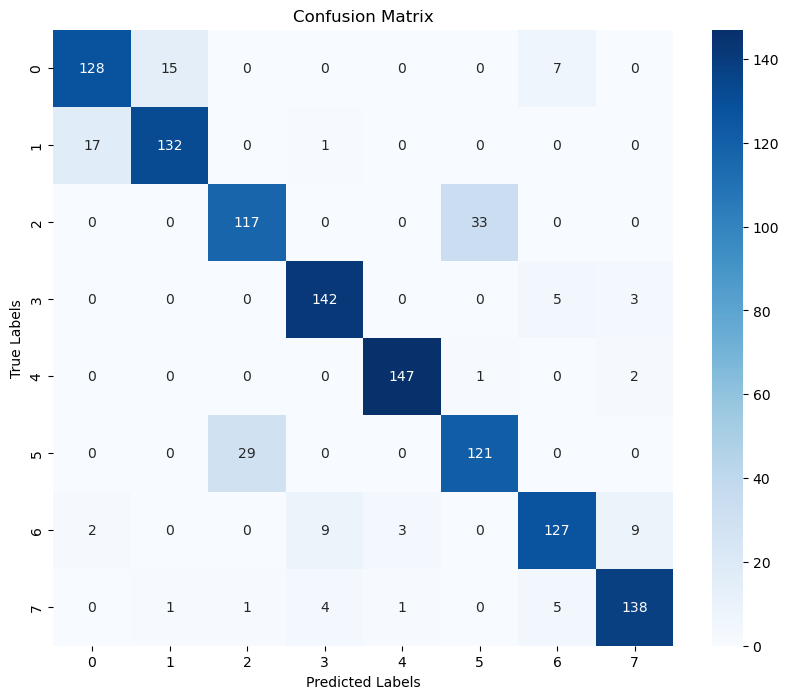

Accuracy: 0.8766666666666667
F1 Score: 0.8764852421575426


In [ ]:
lgbm_classifier = LGBMClassifier(random_state=42)

# Train and evaluate the model
lgbm_accuracy, lgbm_f1, lgbm_cm = train_and_evaluate_model(lgbm_classifier, X_train, y_train, X_test, y_test)
print(f'Accuracy: {lgbm_accuracy}')
print(f'F1 Score: {lgbm_f1}')

### SVM

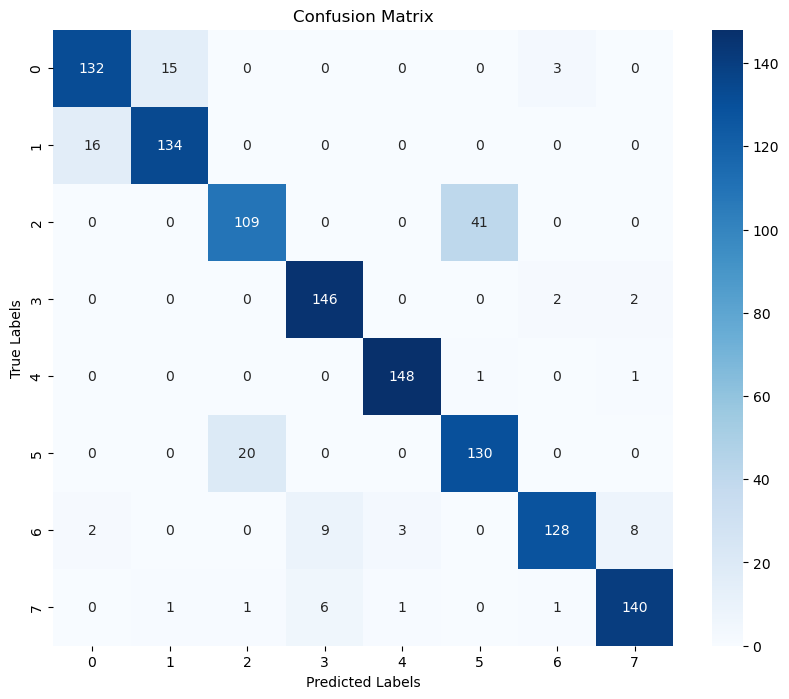

Accuracy: 0.8891666666666667
F1 Score: 0.8887547987050366


In [ ]:
svm_classifier = SVC(random_state=42)

# Train and evaluate the model
svm_accuracy, svm_f1, svm_cm = train_and_evaluate_model(svm_classifier, X_train, y_train, X_test, y_test)
print(f'Accuracy: {svm_accuracy}')
print(f'F1 Score: {svm_f1}')

### AdaBoost

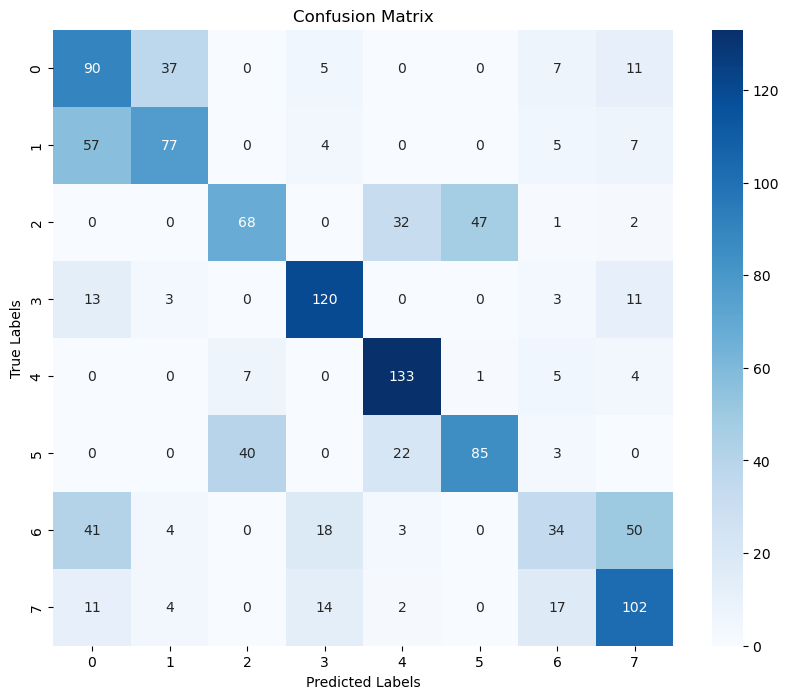

Accuracy: 0.5908333333333333
F1 Score: 0.5785246570458267


In [ ]:
ab_classifier = AdaBoostClassifier(random_state=42)

# Train and evaluate the model
ab_accuracy, ab_f1, ab_cm = train_and_evaluate_model(ab_classifier, X_train, y_train, X_test, y_test)
print(f'Accuracy: {ab_accuracy}')
print(f'F1 Score: {ab_f1}')

### KNN

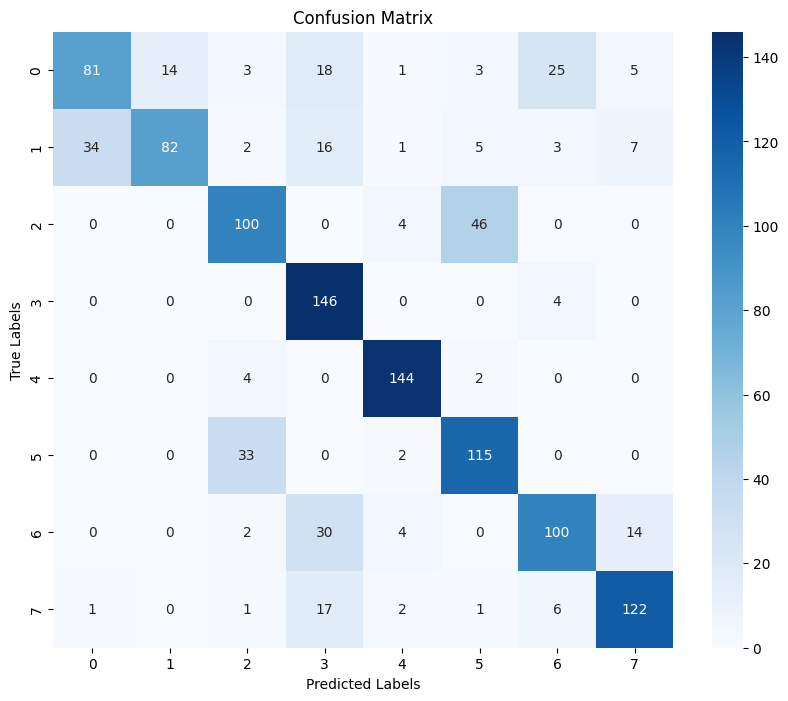

Accuracy: 0.7416666666666667
F1 Score: 0.7363472717343682


In [13]:
knn_classifier = KNeighborsClassifier()

# Train and evaluate the model
knn_accuracy, knn_f1, knn_cm = train_and_evaluate_model(knn_classifier, X_train, y_train, X_test, y_test)
print(f'Accuracy: {knn_accuracy}')
print(f'F1 Score: {knn_f1}')

# Result

| Model           | Accuracy   | F1 Score   |
| --------------- | ---------- | ---------- |
| SVM             | 0.889166   | 0.888754   |
| LightGBM        | 0.876666   | 0.876485   |
| KNN             | 0.741666   | 0.736347   |
| Random Forest   | 0.840833   | 0.840499   |
| AdaBoost        | 0.590833   | 0.578524   |